In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
sys.path.append("../src")
from exlib.explainers.archipelago import ArchipelagoImageCls

In [2]:
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
SEED = 42
if SEED != -1:
    # Torch RNG
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Python RNG
    np.random.seed(SEED)
    random.seed(SEED)

cuda


In [3]:
from torchvision import datasets, transforms

ROOT_DATA_PATH = '/shared_data0/chaenyk/dataset/imagenet'

train_dir = os.path.join(ROOT_DATA_PATH, 'train')
val_dir = os.path.join(ROOT_DATA_PATH, 'val')
json_file = os.path.join(ROOT_DATA_PATH, 'imagenet_class_index.json')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.ImageFolder(train_dir, transform)
val_dataset = datasets.ImageFolder(val_dir, transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False)

In [4]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [5]:
import torch.nn as nn

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [6]:
wrapped_model = WrappedModel(model)
wrapped_model = wrapped_model.to(device)

In [7]:
explainer = ArchipelagoImageCls(wrapped_model)

In [8]:
idx = 0
image, label = next(iter(test_loader))
image.shape, label.shape

(torch.Size([2, 3, 224, 224]), torch.Size([2]))

In [9]:
expln = explainer(image, label)

In [28]:
print(expln._fields)

('attributions', 'explainer_output')


In [32]:
for k, v in expln.explainer_output.items():
    print(k, len(v), v[0].shape)

expln_flat_masks 2 torch.Size([1, 224, 224])
masks 2 torch.Size([44, 224, 224])
mask_weights 2 torch.Size([44])


torch.Size([2, 1, 224, 224])
torch.Size([1, 224, 224])


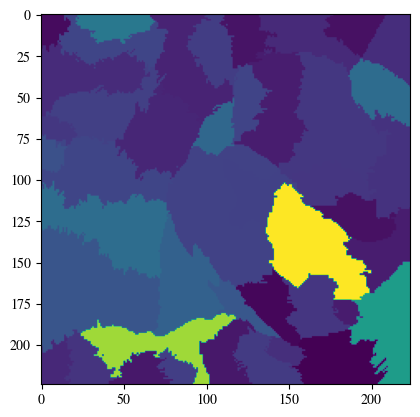

In [11]:
import matplotlib.pyplot as plt

print(expln.attributions.shape)
print(expln.attributions[0].shape)
plt.imshow(expln.attributions[0][0])

In [12]:
def hatch_dim_and_outline(image, mask, c=0.6): 
    black = np.zeros(image.shape)
    dimmed_image = (c*image + (1-c)*black)
    # mask = torch.zeros(image.shape[:2]+(1,))
    # mask[200:300,200:300] = 1
    masked_image = (mask*image + (1-mask)*dimmed_image)
    return masked_image

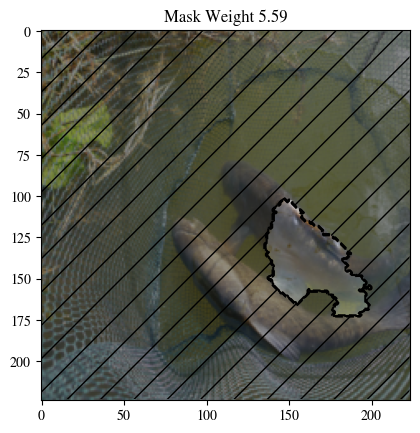

In [26]:
mask = expln.explainer_output['masks'][idx][0].unsqueeze(-1)
mask_weight = expln.explainer_output['mask_weights'][idx][0].cpu().numpy().item()

masked_image = hatch_dim_and_outline((image[0]).permute(1,2,0), mask)
# plt.imshow(((x[0] + 1) / 2).permute(1,2,0).cpu().numpy())
# plt.imshow(proj_mask.numpy(), alpha=0.5)
plt.figure()
plt.imshow(masked_image)
plt.contour(mask[:,:,0], 2, colors='black', linestyles='dashed')
plt.contourf(mask[:,:,0], 2, hatches=['/', None, None],
                cmap='gray', extend='neither', linestyles='--', alpha=0.01)

plt.title(f"Mask Weight {mask_weight:.2f}")
plt.show()